<a href="https://colab.research.google.com/github/heokwon/i-seg-you/blob/main/Efficient_b2_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Aug 30 02:42:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   29C    P8    16W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download

In [1]:
!pip install rasterio efficientnet_pytorch wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 14.6 MB/s 
     |████████████████████████████████| 1.8 MB 62.2 MB/s 
     |████████████████████████████████| 158 kB 78.4 MB/s 
     |████████████████████████████████| 181 kB 58.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 157 kB 67.7 MB/s 
     |████████████████████████████████| 157 kB 72.0 MB/s 
     |████████████████████████████████| 157 kB 58.7 MB/s 
     |████████████████████████████████| 157 kB 64.6 MB/s 
     |████████████████████████████████| 157 kB 77.8 MB/s 
     |████████████████████████████████| 157 kB 74.8 MB/s 
     |████████████████████████████████| 157 kB 62.1 MB/s 
     |████████████████████████████████| 156 kB 68.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=46077c78f1ba5a49b29de74db53b014f735

In [ ]:
# !git clone https://github.com/albumentations-team/albumentations.git

# Wandb login

In [2]:
import os

os.environ["WANDB_NOTEBOOK_NAME"] = "Efficient_b2_test.ipynb"

In [3]:
import wandb
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Efficient_b2_test.ipynb.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Project Name

In [4]:
from fastai.callback.wandb import *

# start logging a wandb run
wandb.init(project='Efficient_b2')
wandb.run.name = 'conv_origin_768_r2_binary_monitor_dice_th'

wandb: Currently logged in as: hukkwon. Use `wandb login --relogin` to force relogin


# Load Dataset

In [ ]:
# ## dataset ids
# 1TR148ijIX14wQd1gqbwlH22aNsDKs7VN # conv_origin_768_r2_binary_dataset
# 1-NLrY-QEuF_VEBTMerK-K8VjWxJ-Xiac # conv_origin_768_r1_binary_dataset
# 1-KPxOC-9yvG9IYf9C3zsRMS8aZ2xeSl5 # conv_origin_512_r2_binary_dataset
# 1-EgqXvM6qZ8ZR8AzfKWrX0VvWSswU5yI # conv_origin_512_r1_binary_dataset
# 1-CC95xAHijLAybbXzNg-W7QQgARBcdex # conv_2048crop_768_r1_binary_dataset
# 1-BiE2_nr6nWFqa6tr6EguEw2UETS6PuU # conv_2048crop_512_r2_binary_dataset
# 1-8-PVIUxsqeXgGrnrcSbSMUOmvL7NJWs # conv_2048crop_512_r1_binary_dataset

In [ ]:
# dataset
!gdown 1TR148ijIX14wQd1gqbwlH22aNsDKs7VN
!unzip ./conv_origin_768_r2_binary_dataset.zip

In [6]:
# train csv
!gdown 1CYzwew45Tuzs1w0oNbraDT4F8RoMlq1O

Downloading...
From: https://drive.google.com/uc?id=1CYzwew45Tuzs1w0oNbraDT4F8RoMlq1O
To: /content/train.csv
100% 16.4M/16.4M [00:00<00:00, 75.4MB/s]


In [7]:
# b0 ~ b7
!gdown 1Sn2pPVCUz2dpzHB935ai-CU9UmTZDyxp
!unzip ./encoder.zip -d ./encoder

Downloading...
From: https://drive.google.com/uc?id=1Sn2pPVCUz2dpzHB935ai-CU9UmTZDyxp
To: /content/encoder.zip
100% 720M/720M [00:07<00:00, 102MB/s]
Archive:  ./encoder.zip
  inflating: ./encoder/efficientnet-b0-08094119.pth  
  inflating: ./encoder/efficientnet-b1-dbc7070a.pth  
  inflating: ./encoder/efficientnet-b2-27687264.pth  
  inflating: ./encoder/efficientnet-b3-c8376fa2.pth  
  inflating: ./encoder/efficientnet-b4-e116e8b3.pth  
  inflating: ./encoder/efficientnet-b5-586e6cc6.pth  
  inflating: ./encoder/efficientnet-b6-c76e70fd.pth  
  inflating: ./encoder/efficientnet-b7-dcc49843.pth  


# Import

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import cv2
import gc
import random
from albumentations import *
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from lovasz import lovasz_hinge
import rasterio
from rasterio.windows import Window
from tqdm.notebook import tqdm

from PIL import Image
import tifffile as tiff

import warnings
warnings.filterwarnings("ignore")

# Parameter & Etc..

In [9]:
dataset_name = 'conv_2048crop_512_r1_binary'
head_epochs = 5
full_epochs = 50
lr_max = 0.5e-2
lr_slice = slice(2e-4,2e-3)
bs = 4
nfolds = 4
fold = 0
SEED = 2020
TRAIN = '/content/conv_768_r2_dataset/images/'
MASKS = '/content/conv_768_r2_dataset/masks/'
LABELS = './train.csv'
NUM_WORKERS = 4
mean = np.array([0.78054955,  0.7566257, 0.7735184]) 
std = np.array([0.25334089, 0.26656769, 0.26202731])

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

# Data preprocessing

In [11]:
# # https://www.kaggle.com/iafoss/256x256-images
# mean = np.array([0.65459856,0.48386562,0.69428385])
# std = np.array([0.15167958,0.23584107,0.13146145])


# https://www.kaggle.com/datasets/thedevastator/hubmap-2022-256x256
# mean = mean
# std = std

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))



class HuBMAPDataset(Dataset):
    def __init__(self, fold=fold, train=True, tfms=None):
        ids = pd.read_csv(LABELS).id.astype(str).values
        kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir(TRAIN) if fname.split('_')[0] in ids]
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)
    


# version 1 0.65 version
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(),
        RandomRotate90(p=1),
        #Morphology
        ShiftScaleRotate(shift_limit=0, scale_limit=(-0.2,0.2), rotate_limit=(-30,30), 
                         interpolation=1, border_mode=0, value=(0,0,0), p=0.5),
        GaussNoise(var_limit=(0,50.0), mean=0, p=0.5),
        GaussianBlur(blur_limit=(3,7), p=0.5),
        #Color
        RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.5, 
                                 brightness_by_max=True,p=0.5),
        HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30, 
                           val_shift_limit=0, p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
    ], p=p)

In [ ]:
# #example of train images with masks
# ds = HuBMAPDataset(tfms=get_aug())
# dl = DataLoader(ds,batch_size=64,shuffle=False,num_workers=NUM_WORKERS)
# imgs,masks = next(iter(dl))

# plt.figure(figsize=(16,16))
# for i,(img,mask) in enumerate(zip(imgs,masks)):
#     img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
#     plt.subplot(8,8,i+1)
#     plt.imshow(img,vmin=0,vmax=255)
#     plt.imshow(mask.squeeze().numpy(), alpha=0.2)
#     plt.axis('off')
#     plt.subplots_adjust(wspace=None, hspace=None)
    
# del ds,dl,imgs,masks

# Model - EfficientUnet

In [12]:
class FPN(nn.Module):
    def __init__(self, input_channels:list, output_channels:list):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
             nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
             nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
            for in_ch, out_ch in zip(input_channels, output_channels)])
        
    def forward(self, xs:list, last_layer):
        hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
               for i,(c,x) in enumerate(zip(self.convs, xs))]
        hcs.append(last_layer)
        return torch.cat(hcs, dim=1)

class UnetBlock(Module):
    def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
                 self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        self.bn = nn.BatchNorm2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = nf if nf is not None else max(up_in_c//2,32)
        self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
        self.conv2 = ConvLayer(nf, nf, norm_type=None,
            xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
        s = left_in
        up_out = self.shuf(up_in)
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))
        
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
        super().__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
        super().__init__()
        self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
            [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
        self.aspps = nn.ModuleList(self.aspps)
        self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
                        nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                        nn.BatchNorm2d(mid_c), nn.ReLU())
        out_c = out_c if out_c is not None else mid_c
        self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
                                    nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
        self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
        self._init_weight()

    def forward(self, x):
        x0 = self.global_pool(x)
        xs = [aspp(x) for aspp in self.aspps]
        x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x0] + xs, dim=1)
        return self.out_conv(x)
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [13]:
pretrained_root = './encoder/'
efficient_net_encoders = {
    "efficientnet-b0": {
        "out_channels": (3, 32, 24, 40, 112, 320),
        "stage_idxs": (3, 5, 9, 16),
        "weight_path": pretrained_root + "efficientnet-b0-08094119.pth"
    },
    "efficientnet-b1": {
        "out_channels": (3, 32, 24, 40, 112, 320),
        "stage_idxs": (5, 8, 16, 23),
        "weight_path": pretrained_root + "efficientnet-b1-dbc7070a.pth"
    },
    "efficientnet-b2": {
        "out_channels": (3, 32, 24, 48, 120, 352),
        "stage_idxs": (5, 8, 16, 23),
        "weight_path": pretrained_root + "efficientnet-b2-27687264.pth"
    },
    "efficientnet-b3": {
        "out_channels": (3, 40, 32, 48, 136, 384),
        "stage_idxs": (5, 8, 18, 26),
        "weight_path": pretrained_root + "efficientnet-b3-c8376fa2.pth"
    },
    "efficientnet-b4": {
        "out_channels": (3, 48, 32, 56, 160, 448),
        "stage_idxs": (6, 10, 22, 32),
        "weight_path": pretrained_root + "efficientnet-b4-e116e8b3.pth"
    },
    "efficientnet-b5": {
        "out_channels": (3, 48, 40, 64, 176, 512),
        "stage_idxs": (8, 13, 27, 39),
        "weight_path": pretrained_root + "efficientnet-b5-586e6cc6.pth"
    },
    "efficientnet-b6": {
        "out_channels": (3, 56, 40, 72, 200, 576),
        "stage_idxs": (9, 15, 31, 45),
        "weight_path": pretrained_root + "efficientnet-b6-c76e70fd.pth"
    },
    "efficientnet-b7": {
        "out_channels": (3, 64, 48, 80, 224, 640),
        "stage_idxs": (11, 18, 38, 55),
        "weight_path": pretrained_root + "efficientnet-b7-dcc49843.pth"
    }
}

In [14]:
import sys
# sys.path.insert(0, '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import url_map, url_map_advprop, get_model_params


class EfficientNetEncoder(EfficientNet):
    def __init__(self, stage_idxs, out_channels, model_name, depth=5):

        blocks_args, global_params = get_model_params(model_name, override_params=None)
        super().__init__(blocks_args, global_params)
        
        cfg = efficient_net_encoders[model_name]

        self._stage_idxs = stage_idxs
        self._out_channels = out_channels
        self._depth = depth
        self._in_channels = 3

        del self._fc
        self.load_state_dict(torch.load(cfg['weight_path']))

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self._conv_stem, self._bn0, self._swish),
            self._blocks[:self._stage_idxs[0]],
            self._blocks[self._stage_idxs[0]:self._stage_idxs[1]],
            self._blocks[self._stage_idxs[1]:self._stage_idxs[2]],
            self._blocks[self._stage_idxs[2]:],
        ]

    def forward(self, x):
        stages = self.get_stages()

        block_number = 0.
        drop_connect_rate = self._global_params.drop_connect_rate

        features = []
        for i in range(self._depth + 1):

            # Identity and Sequential stages
            if i < 2:
                x = stages[i](x)

            # Block stages need drop_connect rate
            else:
                for module in stages[i]:
                    drop_connect = drop_connect_rate * block_number / len(self._blocks)
                    block_number += 1.
                    x = module(x, drop_connect)

            features.append(x)

        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("_fc.bias")
        state_dict.pop("_fc.weight")
        super().load_state_dict(state_dict, **kwargs)  
        

class EffUnet(nn.Module):
    def __init__(self, model_name, stride=1):
        super().__init__()
        
        cfg = efficient_net_encoders[model_name]
        stage_idxs = cfg['stage_idxs']
        out_channels = cfg['out_channels']
        
        self.encoder = EfficientNetEncoder(stage_idxs, out_channels, model_name)

        #aspp with customized dilatations
        self.aspp = ASPP(out_channels[-1], 256, out_c=384, 
                         dilations=[stride*1, stride*2, stride*3, stride*4])
        # self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(384, out_channels[-2], 256)
        self.dec3 = UnetBlock(256, out_channels[-3], 128)
        self.dec2 = UnetBlock(128, out_channels[-4], 64)
        self.dec1 = UnetBlock(64, out_channels[-5], 32)
        self.fpn = FPN([384, 256, 128, 64], [16]*4)
        # self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0, enc1, enc2, enc3, enc4 = self.encoder(x)[-5:]
        enc5 = self.aspp(enc4)
        # dec3 = self.dec4(self.drop_aspp(enc5), enc3)
        dec3 = self.dec4(enc5, enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        # x = self.final_conv(self.drop(x))
        x = self.final_conv(x)
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x
    
#split the model to encoder and decoder for fast.ai
split_layers = lambda m: [
                list(m.encoder.parameters()),
                list(m.aspp.parameters())+list(m.dec4.parameters())+
                list(m.dec3.parameters())+list(m.dec2.parameters())+
                list(m.dec1.parameters())+list(m.fpn.parameters())+
                list(m.final_conv.parameters())
            ]

# Loss & Metrics

In [15]:
def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1.0 - targets))

In [16]:
class Dice_soft(Metric):
    def __init__(self, axis=1): 
        self.axis = axis 
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()
    @property
    def value(self): return 2.0 * self.inter/self.union if self.union > 0 else None
    
# dice with automatic threshold selection
class Dice_th(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.05), axis=1): 
        self.axis = axis
        self.ths = ths
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 
                2.0*self.inter/self.union, torch.zeros_like(self.union))
        return dices.max()

# Model evaluation

In [17]:
#iterator like wrapper that returns predicted and gt masks
class Model_pred:
    def __init__(self, model, dl, tta:bool=True, half:bool=False):
        self.model = model
        self.dl = dl
        self.tta = tta
        self.half = half
        
    def __iter__(self):
        self.model.eval()
        name_list = self.dl.dataset.fnames
        count=0
        with torch.no_grad():
            for x,y in iter(self.dl):
                x = x.cuda()
                if self.half: x = x.half()
                p = self.model(x)
                py = torch.sigmoid(p).detach()
                if self.tta:
                    #x,y,xy flips as TTA
                    flips = [[-1],[-2],[-2,-1]]
                    for f in flips:
                        p = self.model(torch.flip(x,f))
                        p = torch.flip(p,f)
                        py += torch.sigmoid(p).detach()
                    py /= (1+len(flips))
                if y is not None and len(y.shape)==4 and py.shape != y.shape:
                    py = F.upsample(py, size=(y.shape[-2],y.shape[-1]), mode="bilinear")
                py = py.permute(0,2,3,1).float().cpu()
                batch_size = len(py)
                for i in range(batch_size):
                    taget = y[i].detach().cpu() if y is not None else None
                    yield py[i],taget,name_list[count]
                    count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)
    
class Dice_th_pred(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.01), axis=1): 
        self.axis = axis
        self.ths = ths
        self.reset()
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self,p,t):
        pred,targ = flatten_check(p, t)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 2.0*self.inter/self.union, 
                            torch.zeros_like(self.union))
        return dices
    
def save_img(data,name,out):
    data = data.float().cpu().numpy()
    img = cv2.imencode('.png',(data*255).astype(np.uint8))[1]
    out.writestr(name, img)

# Train

In [ ]:
# ## callbacks - early stopping, save model
# cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0, patience=5),
#      SaveModelCallback(monitor='dice_th',comp=np.greater)]

In [18]:
dice = Dice_th_pred(np.arange(0.2,0.7,0.01))
for fold in range(1):
    ds_t = HuBMAPDataset(fold=fold, train=True)
    ds_v = HuBMAPDataset(fold=fold, train=False)
    data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=bs,
                num_workers=NUM_WORKERS,pin_memory=True).cuda()
    model = EffUnet('efficientnet-b2').cuda()
    learn = Learner(data, model, loss_func=symmetric_lovasz,
                metrics=[Dice_soft(),Dice_th()], 
                splitter=split_layers,
                cbs=WandbCallback())
    # .to_fp16(clip=0.5)
    
    #start with training the head
    learn.freeze_to(-1) #doesn't work
    for param in learn.opt.param_groups[0]['params']:
        param.requires_grad = False
    learn.fit_one_cycle(head_epochs, lr_max=lr_max)

    #continue training full model
    learn.unfreeze()
    # learn.fit_one_cycle(full_epochs, lr_max=lr_slice,
    #     cbs=SaveModelCallback(monitor='dice_th',comp=np.greater)) # dice_th 제일 높은 기준으로 저장
    learn.fit_one_cycle(full_epochs, lr_max=lr_slice,
        cbs=SaveModelCallback(monitor='valid_loss',comp=np.less)) # valid_loss 제일 낮은 기준으로 저장
    torch.save(learn.model.state_dict(),f'model_{fold}.pth')
    
    #model evaluation on val and saving the masks
    mp = Model_pred(learn.model,learn.dls.loaders[1])
    with zipfile.ZipFile('val_masks_tta.zip', 'a') as out:
        for p in progress_bar(mp):
            dice.accumulate(p[0],p[1])
            save_img(p[0],p[2],out)
    gc.collect()

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'HuBMAPDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.660331,1.638088,0.329085,0.461609,01:45
1,1.517715,1.477586,0.383813,0.548492,01:36
2,1.373996,1.390953,0.466581,0.607926,01:36
3,1.297979,1.325322,0.479700,0.626721,01:36
4,1.233060,1.330888,0.517395,0.638788,01:36


epoch,train_loss,valid_loss,dice_soft,dice_th,time
0,1.211553,1.299374,0.528678,0.651609,03:12
1,1.182518,1.287952,0.546751,0.654720,03:10
2,1.134927,1.244462,0.579595,0.702094,03:10
3,1.083795,1.248155,0.610511,0.714845,03:10
4,1.053045,1.244945,0.616163,0.714928,03:10
5,1.025791,1.212455,0.636545,0.740416,03:10
6,0.934425,1.148775,0.645452,0.764941,03:10
7,0.879147,1.151328,0.705410,0.792053,03:10
8,0.825282,1.202249,0.723854,0.794125,03:10
9,0.863838,1.142674,0.686652,0.758073,03:10


Better model found at epoch 0 with dice_th value: 0.6516088247299194.
Better model found at epoch 1 with dice_th value: 0.6547200083732605.
Better model found at epoch 2 with dice_th value: 0.7020940184593201.
Better model found at epoch 3 with dice_th value: 0.7148454785346985.
Better model found at epoch 4 with dice_th value: 0.7149280905723572.
Better model found at epoch 5 with dice_th value: 0.7404156923294067.
Better model found at epoch 6 with dice_th value: 0.764941394329071.
Better model found at epoch 7 with dice_th value: 0.7920525074005127.
Better model found at epoch 8 with dice_th value: 0.7941254377365112.
Better model found at epoch 10 with dice_th value: 0.8053478598594666.
Better model found at epoch 11 with dice_th value: 0.8062892556190491.
Better model found at epoch 12 with dice_th value: 0.8214791417121887.
Better model found at epoch 13 with dice_th value: 0.8222601413726807.
Better model found at epoch 16 with dice_th value: 0.842565655708313.
Better model foun

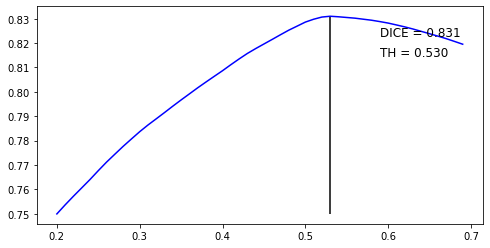

In [ ]:
dices = dice.value
noise_ths = dice.ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()

In [ ]:
# !mkdir {dataset_name}
# !mv ./model_0.pth ./{dataset_name}
# !mv ./model_1.pth ./{dataset_name}
# !mv ./model_2.pth ./{dataset_name}
# !mv ./model_3.pth ./{dataset_name}

In [ ]:
# !zip {dataset_name}.zip -r ./{dataset_name}

	zip warning: name not matched: ./model

zip error: Nothing to do! (try: zip -r ulala.zip . -i ./model)
